<a href="https://colab.research.google.com/github/skothari07/MemeClassifier/blob/master/MemeClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***MEME VS NON-MEME CLASSIFIER***

*Identifies if a image is meme or not using deep learning(CNN).*


***Step 1: Importing dependencies***

In [0]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

import cv2
from PIL import Image

import os
from os.path import exists, join
import shutil
import random

from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.layers import Dense, Conv2D, Embedding, Activation, MaxPooling2D, Dropout
from tensorflow.keras.layers import Flatten, ZeroPadding2D, BatchNormalization
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

from keras.callbacks import TensorBoard,ModelCheckpoint
# Load the TensorBoard notebook extension
%reload_ext tensorboard

Using TensorFlow backend.


***Step 2: Mounting our google drive to get data***


In [0]:
import zipfile
from google.colab import drive
drive.mount('/content/drive', force_remount= True)

#used to unzip our folders containing memes and non memes
'''zip_ref = zipfile.ZipFile("/content/drive/My Drive/MemeClassifier/Data/memes.zip", 'r')
zip_ref.extractall("/content/drive/My Drive/MemeClassifier/Data")
zip_ref.close()
zip_ref1 = zipfile.ZipFile("/content/drive/My Drive/MemeClassifier/Data/nonmemenew.zip", 'r')
zip_ref1.extractall("/content/drive/My Drive/MemeClassifier/Data")
zip_ref1.close()'''
#changing directory to working directory
os.chdir("/content/drive/My Drive/MemeClassifier/Data")

Mounted at /content/drive


**Step 3: Data Splitting into train,test,validate**

In [0]:
#creating directories : train , test , validate
#meme_dir = '/content/drive/My Drive/MemeClassifier/Data/memes'
#notmeme_dir = '/content/drive/My Drive/MemeClassifier/Data/notmemes'
base_dir = '/content/drive/My Drive/MemeClassifier/Data'
if not os.path.exists(base_dir):
    os.mkdir(base_dir)

# Create directories
train_dir = os.path.join(base_dir,'train')
if not os.path.exists(train_dir):
    os.mkdir(train_dir)
validation_dir = os.path.join(base_dir,'validation')
if not os.path.exists(validation_dir):
    os.mkdir(validation_dir)
test_dir = os.path.join(base_dir,'test')
if not os.path.exists(test_dir):
    os.mkdir(test_dir)

train_memes_dir = os.path.join(train_dir,'meme')
if not os.path.exists(train_memes_dir):
    os.mkdir(train_memes_dir)

train_notmemes_dir = os.path.join(train_dir,'notmeme')
if not os.path.exists(train_notmemes_dir):
    os.mkdir(train_notmemes_dir)

validation_memes_dir = os.path.join(validation_dir,'meme')
if not os.path.exists(validation_memes_dir):
    os.mkdir(validation_memes_dir)

validation_notmemes_dir = os.path.join(validation_dir, 'notmeme')
if not os.path.exists(validation_notmemes_dir):
    os.mkdir(validation_notmemes_dir)

test_memes_dir = os.path.join(test_dir, 'meme')     
if not os.path.exists(test_memes_dir):
    os.mkdir(test_memes_dir)

test_notmemes_dir = os.path.join(test_dir, 'notmeme')
if not os.path.exists(test_notmemes_dir):
    os.mkdir(test_notmemes_dir)

#split data
#this is used if we have image in .csv file . Not used in this case
'''
#Meme 
meme_files = [array of meme images]
meme_files.sort()  # make sure that the filenames have a fixed order before shuffling
random.seed(230)
random.shuffle(meme_files) # shuffles the ordering of filenames (deterministic given the chosen seed)

split_1 = int(0.8 * len(meme_files))
split_2 = int(0.9 * len(meme_files))
train_meme_files = meme_files[:split_1]
validate_meme_files = meme_files[split_1:split_2]
test_meme_files = meme_files[split_2:]

#Not-meme
notmeme_files = [array of non meme images]
notmeme_files.sort()  # make sure that the filenames have a fixed order before shuffling
random.seed(230)
random.shuffle(notmeme_files) # shuffles the ordering of filenames (deterministic given the chosen seed)

split_12 = int(0.8 * len(notmeme_files))
split_22 = int(0.9 * len(nonmeme_files))
train_nonmeme_files = nonmeme_files[:split_12]
validate_nonmeme_files = nonmeme_files[split_12:split_22]
test_nonmeme_files = nonmeme_files[split_22:]
'''

***Step 4: Preparing data (Data pre-processing)***

In [0]:
# create data generators
train_datagen = ImageDataGenerator(rescale=1.0/255.0,	width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)
val_datagen = ImageDataGenerator(rescale=1.0/255.0,width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
# prepare iterators
train_it = train_datagen.flow_from_directory('/content/drive/My Drive/MemeClassifier/Data/train',class_mode='binary', batch_size=16, target_size=(150, 150))
val_it = val_datagen.flow_from_directory('/content/drive/My Drive/MemeClassifier/Data/validation',class_mode='binary', batch_size=16, target_size=(150, 150))
# load and iterate test dataset
test_it = test_datagen.flow_from_directory('/content/drive/My Drive/MemeClassifier/Data/test', class_mode='binary', batch_size=16, target_size=(150, 150))

Found 3456 images belonging to 2 classes.
Found 1128 images belonging to 2 classes.
Found 550 images belonging to 2 classes.


***Step 5: Model***

In [0]:
#transfer learning using MobileNet_V2
model_mobilenet_v2 = tf.keras.applications.MobileNetV2(input_shape=(150,150,3) ,include_top=False, weights='imagenet')

model = tf.keras.Sequential()

#freezing mobilenet_v2 layers (saving its original weights)
model_mobilenet_v2.trainable = False
#copy mobilenet_v2 layers into our model
model.add(model_mobilenet_v2)
#Adding our own layers
model.add(tf.keras.layers.GlobalAveragePooling2D())  # this converts our 3D feature maps to 1D feature vectors
model.add(tf.keras.layers.Dense(128 , activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1 , activation='sigmoid'))

model.compile(optimizer='Adam', metrics=['accuracy'], loss='binary_crossentropy')

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               163968    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 2,422,081
Trainable params: 164,097
Non-trainable params: 2,257,984
_________________________________________________________________


***Step 6: Training***

In [0]:
early_stop = EarlyStopping(monitor='val_loss',patience=5)
#train/validate model
history = model.fit(train_it, epochs=20, validation_data=val_it , verbose=1,callbacks = [early_stop])

Epoch 1/20
216/216 [==============================] - 159s 734ms/step - loss: 0.2780 - accuracy: 0.8950 - val_loss: 0.3007 - val_accuracy: 0.8785
Epoch 2/20
216/216 [==============================] - 161s 747ms/step - loss: 0.2075 - accuracy: 0.9219 - val_loss: 0.2344 - val_accuracy: 0.9078
Epoch 3/20
216/216 [==============================] - 158s 729ms/step - loss: 0.1830 - accuracy: 0.9297 - val_loss: 0.2232 - val_accuracy: 0.9149
Epoch 4/20
216/216 [==============================] - 158s 731ms/step - loss: 0.1740 - accuracy: 0.9323 - val_loss: 0.2109 - val_accuracy: 0.9167
Epoch 5/20
216/216 [==============================] - 155s 717ms/step - loss: 0.1652 - accuracy: 0.9387 - val_loss: 0.2804 - val_accuracy: 0.8892
Epoch 6/20
216/216 [==============================] - 160s 742ms/step - loss: 0.1445 - accuracy: 0.9468 - val_loss: 0.2777 - val_accuracy: 0.8989
Epoch 7/20
216/216 [==============================] - 158s 733ms/step - loss: 0.1388 - accuracy: 0.9473 - val_loss: 0.2404 -

***Step 7: Visualization***

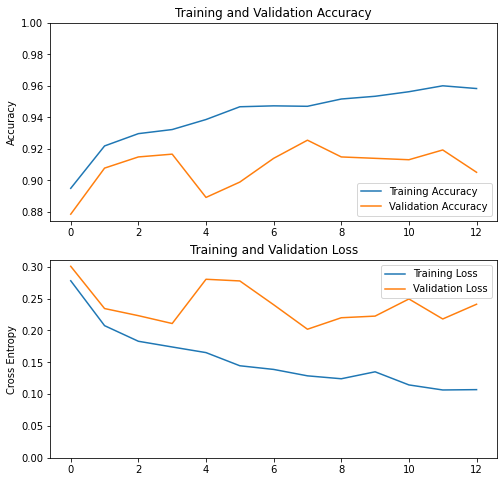

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

***Step 8: Prediction***

In [0]:
prediction = model.predict(test_it)
print(prediction)